In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import ndimage as ndi

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

np.random.seed(0)
%matplotlib inline

In [2]:
import sys
sys.path.append('../src/')

from model import UNet
from dataset import SSSDataset
from utils import gen_color_img

In [3]:
n_sticks = 8

In [4]:
# Model
model = UNet().cuda()
model.eval()

model_dir = Path('../model')
model_path = model_dir.joinpath('model.pth')

param = torch.load(model_path)
model.load_state_dict(param)

In [5]:
# Dataset for inference
test_dataset = SSSDataset(train=False, n_sticks=n_sticks, data_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16,
                             shuffle=False, num_workers=0,
                             pin_memory=True)

In [6]:
# Inference
images = []
sem_pred = []
ins_pred = []
for images_ in test_dataloader:
    images.append(images_.numpy())
    images_ = Variable(images_, volatile=True).cuda()
    sem_pred_, ins_pred_ = model(images_)
    sem_pred.append(F.softmax(sem_pred_, dim=1).cpu().data.numpy())
    ins_pred.append(ins_pred_.cpu().data.numpy())

images = np.concatenate(images)[:, 0].astype(np.uint8)
sem_pred = np.concatenate(sem_pred)[:, 1, :, :]
ins_pred = np.concatenate(ins_pred)

In [7]:
# Post Processing
p_sem_pred = []
for sp in sem_pred:
    p_sem_pred.append(ndi.morphology.binary_fill_holes(sp > 0.5))

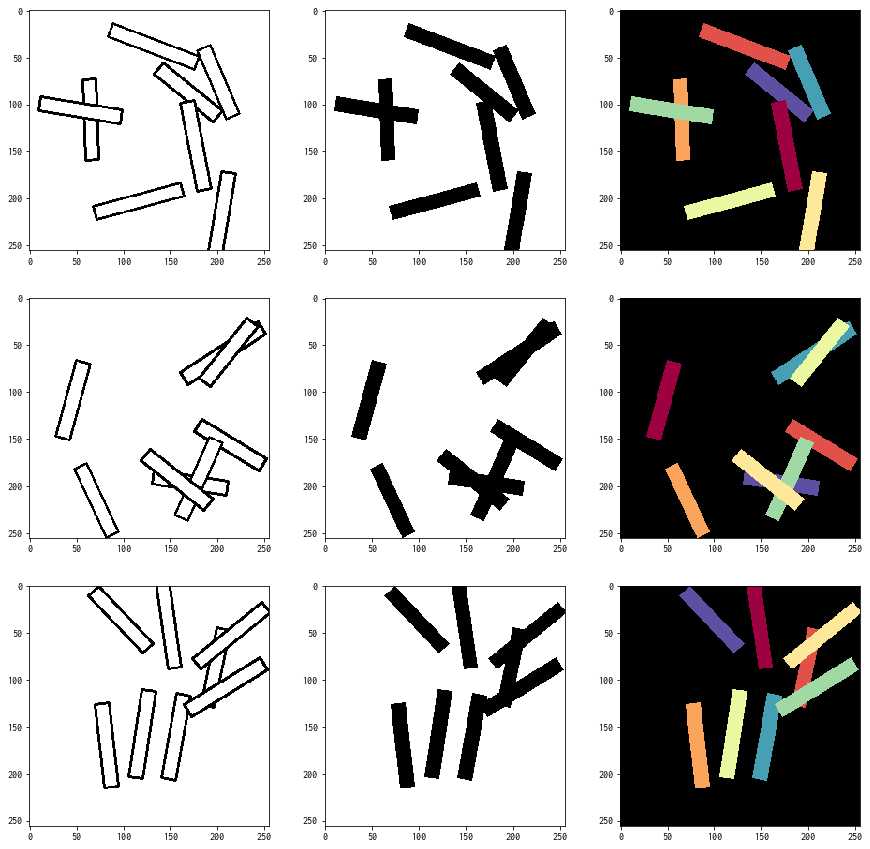

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
plt.gray()

for i, ax_ in enumerate(axes):
    color_img = gen_color_img(p_sem_pred[i], ins_pred[i], n_sticks)
    ax_[0].imshow(images[i])
    ax_[1].imshow(~p_sem_pred[i])
    ax_[2].imshow(color_img)